# Imports

In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


# Data importing

In [ ]:
train = pd.read_csv('appliances_keras_sentiment.csv')
train.head()

,review_text,rating_class
0,complete package I like the fact that the wire...,good
1,Perfect Fit Needed another couple of feet with...,good
2,Everything works Good quality at a reasonable ...,good
3,50 amp cable Planning on hooking this to my RV,good
4,"Good range cord, standard nema 14-50p fits wit...",good


# Data exploration

In [ ]:
#Let's get the dataset length
len(train)

446474

In [ ]:
#Is there any other different value than neutral, negative and positive?
train['rating_class'].unique()

array(['good', 'bad'], dtype=object)

In [ ]:
#How's distributed the dataset? Is it biased?
train.groupby('rating_class').nunique()

,review_text
rating_class,
bad,47985
good,344648


In [ ]:
train_full = train

In [ ]:
# New dataset that has better distribution of good/bad
train = train_full.sort_values(by='rating_class')
train.head()

,review_text,rating_class
184830,One Star Housing came broken,bad
366770,"Not helpful for ""traveling"" washing machine Th...",bad
68558,doesn't work. Does not stick to granite's roug...,bad
188932,Jenn-Air knob No problem with the purchase. Ho...,bad
210194,"One Star I returned the item, it didn't fit my...",bad


In [ ]:
train = train[:120000]
train.groupby('rating_class').nunique()

,review_text
rating_class,
bad,47985
good,63721


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
#Is there any null value?
train["review_text"].isnull().sum()

0

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = train['review_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['One Star Housing came broken',
 'Not helpful for "traveling" washing machine These did not help our "traveling" washer at all, which vibrates so hard in the spin cycle it moves around the floor. Vibrated right off the pads.',
 'doesnt work. Does not stick to granites rough surface and it needs a smaller profile, does not allow the dishwasher door to shut. Disappointed.',
 'Jenn-Air knob No problem with the purchase. However, the knobs are cheap plastic. I dont understand why they are not aluminum or some other metal. The price is good enough, but the postage is ridiculously high. Jenn-Air, when contacted, showed no interest in considering suggestions related to the poor quality of the knobs. I would suggest buying another brand in the future.',
 'One Star I returned the item, it didnt fit my dryer.']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['one', 'star', 'housing', 'came', 'broken'], ['not', 'helpful', 'for', 'traveling', 'washing', 'machine', 'these', 'did', 'not', 'help', 'our', 'traveling', 'washer', 'at', 'all', 'which', 'vibrates', 'so', 'hard', 'in', 'the', 'spin', 'cycle', 'it', 'moves', 'around', 'the', 'floor', 'vibrated', 'right', 'off', 'the', 'pads'], ['doesnt', 'work', 'does', 'not', 'stick', 'to', 'granites', 'rough', 'surface', 'and', 'it', 'needs', 'smaller', 'profile', 'does', 'not', 'allow', 'the', 'dishwasher', 'door', 'to', 'shut', 'disappointed'], ['jenn', 'air', 'knob', 'no', 'problem', 'with', 'the', 'purchase', 'however', 'the', 'knobs', 'are', 'cheap', 'plastic', 'dont', 'understand', 'why', 'they', 'are', 'not', 'aluminum', 'or', 'some', 'other', 'metal', 'the', 'price', 'is', 'good', 'enough', 'but', 'the', 'postage', 'is', 'ridiculously', 'high', 'jenn', 'air', 'when', 'contacted', 'showed', 'no', 'interest', 'in', 'considering', 'suggestions', 'related', 'to', 'the', 'poor', 'quality', 'of'

In [ ]:
len(data_words)

120000

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['one star housing came broken', 'not helpful for traveling washing machine these did not help our traveling washer at all which vibrates so hard in the spin cycle it moves around the floor vibrated right off the pads', 'doesnt work does not stick to granites rough surface and it needs smaller profile does not allow the dishwasher door to shut disappointed', 'jenn air knob no problem with the purchase however the knobs are cheap plastic dont understand why they are not aluminum or some other metal the price is good enough but the postage is ridiculously high jenn air when contacted showed no interest in considering suggestions related to the poor quality of the knobs would suggest buying another brand in the future', 'one star returned the item it didnt fit my dryer']


In [ ]:
data = np.array(data)
data[:5]

array(['one star housing came broken',
       'not helpful for traveling washing machine these did not help our traveling washer at all which vibrates so hard in the spin cycle it moves around the floor vibrated right off the pads',
       'doesnt work does not stick to granites rough surface and it needs smaller profile does not allow the dishwasher door to shut disappointed',
       'jenn air knob no problem with the purchase however the knobs are cheap plastic dont understand why they are not aluminum or some other metal the price is good enough but the postage is ridiculously high jenn air when contacted showed no interest in considering suggestions related to the poor quality of the knobs would suggest buying another brand in the future',
       'one star returned the item it didnt fit my dryer'],
      dtype='<U11463')

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [ ]:
labels = np.array(train['rating_class'])
y = []
for i in range(len(labels)):
    if labels[i] == 'bad':
        y.append(0)
    if labels[i] == 'good':
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="float32")
del y # deletes the object y from memory, since it's no longer necessary

In [ ]:
len(labels)

120000

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
reviews = pad_sequences(sequences, maxlen=max_len)
print(reviews)

[[   0    0    0 ...  727  123  249]
 [   0    0    0 ...  101    1 1527]
 [   0    0    0 ...    4  863  228]
 ...
 [   0    0    0 ...   14   25   56]
 [   0    0    0 ...  234  478  258]
 [   0    0    0 ...  843   46  144]]


In [ ]:
len(reviews[0])

200

In [ ]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#Splitting the data
# X_train, X_test, y_train, y_test = train_test_split(reviews,labels, test_size=0.05, stratify=labels)
# Tuninig the ratio for new good/bad set
X_train, X_test, y_train, y_test = train_test_split(reviews,labels, test_size=0.1, stratify=labels)
print (len(X_train),len(X_test),len(y_train),len(y_test))

108000 12000 108000 12000


In [ ]:
#Splitting train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((86400, 200), (21600, 200), (86400, 2), (21600, 2), (12000, 200), (12000, 2))

# Model building

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

## Single LSTM layer model

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 20))
model0.add(layers.LSTM(15,dropout=0.5))
model0.add(layers.Dense(2,activation='softmax'))


model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=70,validation_data=(X_val, y_val),callbacks=[checkpoint0])

Epoch 1/70
2700/2700 [==============================] - 117s 42ms/step - loss: 0.2778 - accuracy: 0.8779 - val_loss: 0.1448 - val_accuracy: 0.9485

Epoch 00001: val_accuracy improved from -inf to 0.94852, saving model to best_model0.hdf5
Epoch 2/70
2700/2700 [==============================] - 113s 42ms/step - loss: 0.1382 - accuracy: 0.9482 - val_loss: 0.1469 - val_accuracy: 0.9486

Epoch 00002: val_accuracy improved from 0.94852 to 0.94856, saving model to best_model0.hdf5
Epoch 3/70
2700/2700 [==============================] - 114s 42ms/step - loss: 0.1330 - accuracy: 0.9502 - val_loss: 0.1355 - val_accuracy: 0.9502

Epoch 00003: val_accuracy improved from 0.94856 to 0.95019, saving model to best_model0.hdf5
Epoch 4/70
2700/2700 [==============================] - 113s 42ms/step - loss: 0.1289 - accuracy: 0.9528 - val_loss: 0.1370 - val_accuracy: 0.9509

Epoch 00004: val_accuracy improved from 0.95019 to 0.95093, saving model to best_model0.hdf5
Epoch 5/70
2700/2700 [=================

2700/2700 [==============================] - 113s 42ms/step - loss: 0.1100 - accuracy: 0.9605 - val_loss: 0.1318 - val_accuracy: 0.9513

Epoch 00039: val_accuracy did not improve from 0.95431
Epoch 40/70
2700/2700 [==============================] - 115s 42ms/step - loss: 0.1113 - accuracy: 0.9593 - val_loss: 0.1331 - val_accuracy: 0.9506

Epoch 00040: val_accuracy did not improve from 0.95431
Epoch 41/70
2700/2700 [==============================] - 113s 42ms/step - loss: 0.1148 - accuracy: 0.9586 - val_loss: 0.1309 - val_accuracy: 0.9510

Epoch 00041: val_accuracy did not improve from 0.95431
Epoch 42/70
2700/2700 [==============================] - 122s 45ms/step - loss: 0.1131 - accuracy: 0.9582 - val_loss: 0.1504 - val_accuracy: 0.9486

Epoch 00042: val_accuracy did not improve from 0.95431
Epoch 43/70
2700/2700 [==============================] - 128s 48ms/step - loss: 0.1128 - accuracy: 0.9595 - val_loss: 0.1356 - val_accuracy: 0.9518

Epoch 00043: val_accuracy did not improve from 

In [ ]:
best_model = keras.models.load_model("best_model0.hdf5")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)
predictions = best_model.predict(X_test)

375/375 - 5s - loss: 0.1267 - accuracy: 0.9553
Model accuracy:  0.9553333520889282


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

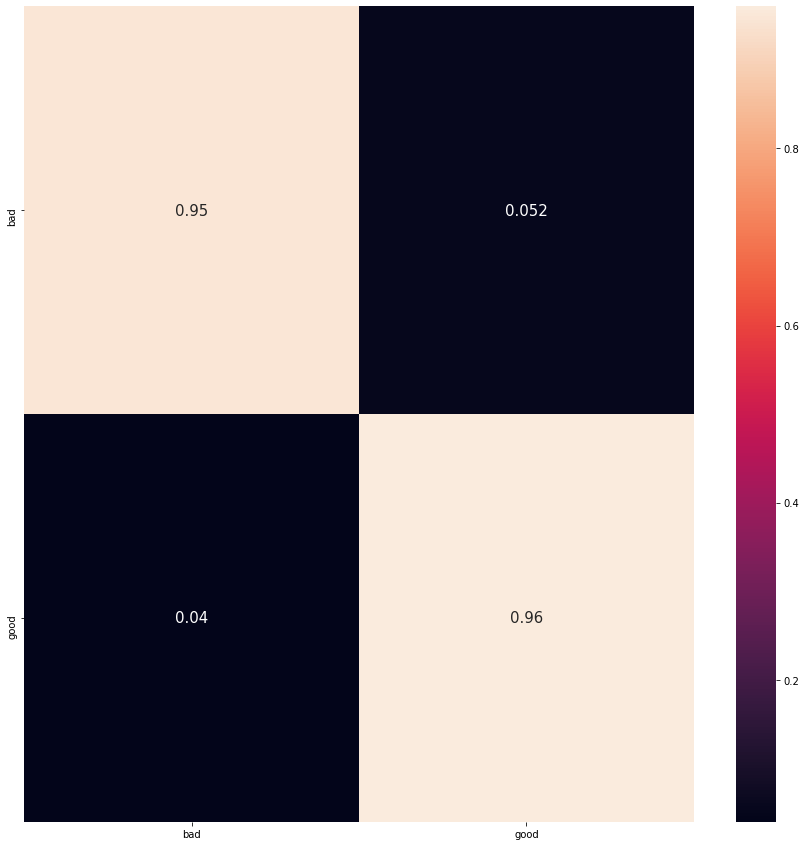

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['bad', 'good'], columns=['bad', 'good'])
# Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.show()